<a href="https://colab.research.google.com/github/cerezamo/dl_ensae2020/blob/master/TEST_USPS_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning - CycleGAN - ENSAE 2020 

## From MNIST to USPS 

### Import packages 

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variab²  le
from torch import optim
import torchvision.utils as utils
import torch.nn.functional as F
import torch.utils as tutils
from torchvision import datasets
from torchvision import transforms
import numpy as np

This code is adapted from [yunjey](https://github.com/yunjey/) and the assignment proposed. 

### Dictionnary of parameters we will use

### Download and construct loaders for USPS and Mnist

In [0]:
# We set the batch size to 64
# We choose an image size of 20 , moreover, MNIST images are slightly cropped at the center. 
# Recall that USPS image size is 16 and MNIST image size is 28. 
batch_size = 64
image_size = 32

In [0]:
def get_loader_mnist(image_size,batch_size):
  transform = transforms.Compose([
                    transforms.CenterCrop(22),
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                    ])
  
  mnist_train = datasets.MNIST(root='content/',download=True, transform = transform,train=True)
  mnist_test = datasets.MNIST(root='content/',download=True, transform = transform,train=False)

  train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                             batch_size=batch_size,
                                             shuffle=True)
  
  test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                             batch_size=batch_size,
                                             shuffle=False)
  
  return train_loader, test_loader 

In [0]:
def get_loader_usps(image_size,batch_size):
  transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,), (0.5,))
                    ])
  
  usps_train = datasets.USPS(root='content/',download=True, transform = transform,train=True)
  usps_test = datasets.USPS(root='content/',download=True, transform = transform,train=False)

  train_loader = torch.utils.data.DataLoader(dataset=usps_train,
                                             batch_size=batch_size,
                                             shuffle=True)
  
  test_loader = torch.utils.data.DataLoader(dataset=usps_test,
                                             batch_size=batch_size,
                                             shuffle=False)
  
  return train_loader, test_loader 

In [0]:
M_train_loader, M_test_loader =get_loader_mnist(image_size,batch_size)

In [0]:
U_train_loader, U_test_loader =get_loader_usps(image_size,batch_size)

In [0]:
examples_mnist = enumerate(M_train_loader)
batch_idx, (example_data_mnist, example_targets_mnist) = next(examples_mnist)

examples_usps = enumerate(U_train_loader)
batch_idx, (example_data_usps, example_targets_usps) = next(examples_usps)

In [0]:
example_data_usps.shape, example_data_mnist.shape # 64 per batch, size 32x32  # 64 per batch, size 32x32 

(torch.Size([64, 1, 32, 32]), torch.Size([64, 1, 32, 32]))

In [0]:
list_label = []
list_images = []

while len(list_label)<10:
  for i in range(len(example_targets_mnist)):
    if example_targets_mnist[i].item() in list_label:
      pass
    else:
      list_label.append(example_targets_mnist[i].item())
      list_images.append(example_data_mnist[i])

list_label,list_images = zip(*sorted(zip(list_label,list_images)))

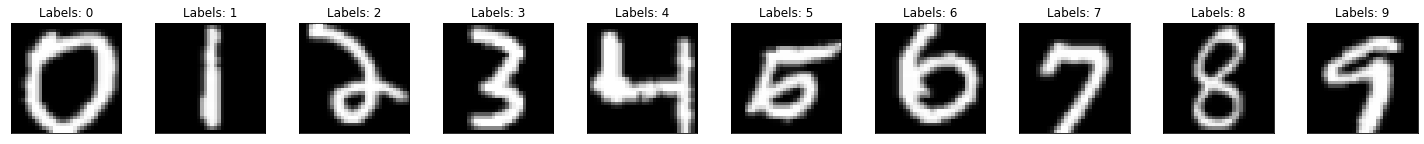

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,12))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.tight_layout()
  plt.imshow(list_images[i][0],cmap='gray', interpolation='none')
  plt.title("Labels: {}".format(list_label[i]))
  plt.xticks([])
  plt.yticks([])

In [0]:
list_label = []
list_images = []

while len(list_label)<10:
  for i in range(len(example_targets_usps)):
    if example_targets_usps[i].item() in list_label:
      pass
    else:
      list_label.append(example_targets_usps[i].item())
      list_images.append(example_data_usps[i])

list_label,list_images = zip(*sorted(zip(list_label,list_images)))

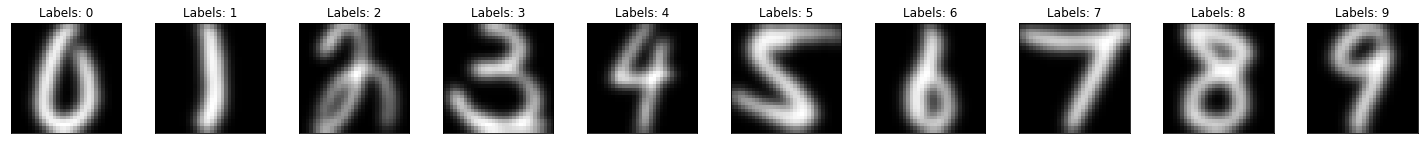

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,12))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.tight_layout()
  plt.imshow(list_images[i][0],cmap='gray', interpolation='none')
  plt.title("Labels: {}".format(list_label[i]))
  plt.xticks([])
  plt.yticks([])

In [0]:
example_data_mnist.size()

torch.Size([64, 1, 32, 32])

The USPS dataset consists of 7,291 training images and 2007 test images each of which is of the original size of 16x16. The MNIST dataset consists of 60 000 training images and 10 000 test images each of which is of the size 28x28. Both contains 10 categories (numbers from 0 to 9) and follow distinct distributions. 

#### Helper functions

In [0]:
import torch.nn as nn

In [0]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom deconvolutional layer """
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def conv(c_in, c_out, k_size, stride=2, pad=1, batch_norm=True):
    """Custom convolutional layer"""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

# Batch norm True False (last layer)

Construction of the two discriminators 

In [0]:
class D_MNIST(nn.Module):
    """Discriminator for mnist."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D_MNIST, self).__init__()
        self.conv1 = conv(1, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

class D_USPS(nn.Module):
    """Discriminator for usps."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D_USPS, self).__init__()
        self.conv1 = conv(1, conv_dim, 4, batch_norm=False) #1
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out


Creating the two generators 

In [0]:
class G_MNIST_USPS(nn.Module):
    """Generator for transfering from mnist to usps"""
    def __init__(self, conv_dim=64):
        super(G_MNIST_USPS, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, batch_norm=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)

        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 3, 32, 32)
        return out

class G_USPS_MNIST(nn.Module):
    """Generator for transfering from usps to mnist"""
    def __init__(self, conv_dim=64):
        super(G_USPS_MNIST, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, batch_norm=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)

        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 1, 32, 32)
        return out


Building model 

In [0]:
def print_models(G_MtoU, G_UtoM, D_M, D_U):
    """Prints model information for the generators and discriminators.
    """
    print("                 G_MtoU                ")
    print("---------------------------------------")
    print(G_MtoU)
    print("---------------------------------------")

    print("                 G_UtoM                ")
    print("---------------------------------------")
    print(G_UtoM)
    print("---------------------------------------")

    print("                  D_M                  ")
    print("---------------------------------------")
    print(D_M)
    print("---------------------------------------")

    print("                  D_U                  ")
    print("---------------------------------------")
    print(D_U)
    print("---------------------------------------")

In [0]:
def create_model():
  G_MtoU = G_MNIST_USPS()
  G_UtoM = G_USPS_MNIST()
  D_M = D_MNIST()
  D_U = D_USPS()

  print_models(G_MtoU, G_UtoM, D_M, D_U)

  if torch.cuda.is_available():
      G_MtoU.cuda()
      G_UtoM.cuda()
      D_M.cuda()
      D_U.cuda()
      print('Models moved to GPU.')
  return G_MtoU,G_UtoM, D_M, D_U

In [0]:
def save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU):
    """Saves samples from both generators M->U and U->M.
    """
    import os
    import imageio
    fake_M = G_UtoM(fixed_U)
    fake_U = G_MtoU(fixed_M)

    M, fake_M = to_data(fixed_M), to_data(fake_M)
    U, fake_U = to_data(fixed_U), to_data(fake_U)

    merged = merge_images(M, fake_U)
    path = os.path.join('/content/', 'sample-{:06d}-M-U.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

    merged = merge_images(U, fake_M)
    path = os.path.join('/content/', 'sample-{:06d}-U-M.png'.format(iteration))
    imageio.imwrite(path, merged)
    print('Saved {}'.format(path))

In [0]:
def merge_images(sources, targets, k=10):
    """Creates a grid consisting of pairs of columns, where the first column in
    each pair contains images source images and the second column in each pair
    contains images generated by the CycleGAN from the corresponding images in
    the first column.
    """
    _, _, h, w = sources.shape
    row = int(np.sqrt(64))
    merged = np.zeros([3, row*h, row*w*2]) # 3
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    return merged.transpose(1, 2, 0)

Helper functions 

In [0]:
def to_var(x):
    """Converts numpy to variable."""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

### Training loop

In [0]:
# Check number of parameters in the generator
pytorch_total_params = sum(p.numel() for p in G_MNIST_USPS().parameters())
pytorch_total_params

560128

In [0]:
def training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader, sample_every=1000,  lr=0.0002, train_iters=20000, log_step = 10, batch_size=64, use_cycle_consistency_loss=True):
  # Create generators and discriminators
  G_MtoU, G_UtoM, D_M, D_U = create_model()

  g_params = list(G_MtoU.parameters()) + list(G_UtoM.parameters())  # Get generator parameters
  d_params = list(D_M.parameters()) + list(D_U.parameters())  # Get discriminator parameters

  # Create optimizers for the generators and discriminators
  g_optimizer = optim.Adam(g_params, lr)
  d_optimizer = optim.Adam(d_params, lr)

  iter_M = iter(M_train_loader)
  iter_U = iter(U_train_loader)

  test_iter_M = iter(M_test_loader)
  test_iter_U = iter(U_test_loader)

  # Get some fixed data from domains X and Y for sampling. These are images that are held
  # constant throughout training, that allow us to inspect the model's performance.
  fixed_M = to_var(test_iter_M.next()[0])
  fixed_U = to_var(test_iter_U.next()[0])

  iter_per_epoch = min(len(iter_M), len(iter_U))

  for iteration in range(1, train_iters+1):

      # Reset data_iter for each epoch
      if iteration % iter_per_epoch == 0:
          iter_M = iter(M_train_loader)
          iter_U = iter(U_train_loader)

      images_M, labels_M = iter_M.next()
      images_M, labels_M = to_var(images_M), to_var(labels_M).long().squeeze()

      images_U, labels_U = iter_U.next()
      images_U, labels_U = to_var(images_U), to_var(labels_U).long().squeeze()

     # num_classes = 10

      #if use_labels:
      #  M_fake_labels = to_var(
       #     torch.Tensor([num_classes]*images_U.size(0)).long())
        #svhn_fake_labels = to_var(
         #   torch.Tensor([num_classes]*images_M.size(0)).long())


      # ============================================
      #            TRAIN THE DISCRIMINATORS
      # ============================================

      # Train with real images
      d_optimizer.zero_grad()

      # Compute the discriminator losses on real images
      out_M = D_M(images_M) # discriminator mnist true
      D_M_loss = torch.mean((out_M-1)**2) 


      out_U = D_U(images_U)
      D_U_loss = torch.mean((out_U-1)**2)

      d_real_loss = D_M_loss + D_U_loss
      d_real_loss.backward()
      d_optimizer.step()

      # Train with fake images
      d_optimizer.zero_grad()

      # Generate fake images that look like domain MNIST based on real images in domain USPS
      fake_M = G_UtoM(images_U)

      # Compute the loss for D_M
      out_M = D_M(fake_M)
      D_M_loss = torch.mean(out_M**2) 

      # 4. Generate fake images that look like domain U based on real images in domain M
      fake_U = G_MtoU(images_M)

      # 5. Compute the loss for D_U
      out_U = D_U(fake_U)
      D_U_loss = torch.mean((out_U)**2) 

      d_fake_loss = D_M_loss + D_U_loss
      d_fake_loss.backward()
      d_optimizer.step()



      # =========================================
      #            TRAIN THE GENERATORS
      # =========================================

      ## U--M-->U 

      g_optimizer.zero_grad()

      # 1. Generate fake images that look like domain M based on real images in domain U
      fake_M = G_UtoM(images_U)
      out = D_M(fake_M)

      # 2. Compute the generator loss based on domain M

      g_loss = torch.mean((out-1)**2)

      if use_cycle_consistency_loss:
          reconstructed_U = G_MtoU(fake_M)
          # 3. Compute the cycle consistency loss (the reconstruction loss)
          cycle_consistency_loss = torch.mean((images_U - reconstructed_U)**2)
          g_loss += cycle_consistency_loss

      g_loss.backward()
      g_optimizer.step()

      ## M--U-->M 

      g_optimizer.zero_grad()

      # 1. Generate fake images that look like domain U based on real images in domain M
      fake_U = G_MtoU(images_M)
      out = D_U(fake_U)

      # 2. Compute the generator loss based on domain U
      g_loss = torch.mean((out-1)**2)

      if use_cycle_consistency_loss:
          reconstructed_M = G_UtoM(fake_U)
          # 3. Compute the cycle consistency loss (the reconstruction loss)
          cycle_consistency_loss = torch.mean((images_M - reconstructed_M)**2)
          g_loss += cycle_consistency_loss

      g_loss.backward()
      g_optimizer.step()


      # Print the log info
      if iteration % log_step == 0:
          print('Iteration [{:5d}/{:5d}] | d_real_loss: {:6.4f} | d_U_loss: {:6.4f} | d_M_loss: {:6.4f} | '
                'd_fake_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                  iteration, train_iters, d_real_loss.item(), D_U_loss.item(),
                  D_M_loss.item(), d_fake_loss.item(), g_loss.item()))


      # Save the generated samples
      if iteration % sample_every == 0:
          save_samples(iteration, fixed_U, fixed_M, G_UtoM, G_MtoU)

In [0]:
training_loop(M_train_loader, U_train_loader, M_test_loader, U_test_loader, sample_every=1000,  lr=0.0002, train_iters=5000, log_step = 100,  use_cycle_consistency_loss=True)

                 G_MtoU                
---------------------------------------
G_MNIST_USPS(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(